<a href="https://colab.research.google.com/github/rb2022/ET5003_SEM1_2021-2/blob/main/ET5003_Kaggle_RobertBarrett_20157347.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_KaggleCompetition

In [2]:
#@title Current Date
Today = '2021-10-06' #@param {type:"date"}


In [3]:
#@markdown ---
#@markdown ### Enter your details here:
Team_Number = "5" #@param {type:"string"}
Student_ID&Name = "" #@param {type:"string"}
Student_ID&Name = "" #@param {type:"string"}
Student_ID&Name = "" #@param {type:"string"}
Student_ID&Name = "" #@param {type:"string"}
Student_ID&Name = "" #@param {type:"string"}
#@markdown ---

SyntaxError: ignored

In [ ]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = Final #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# INTRODUCTION

Your introduction here.

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [4]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [7]:
# Scikit-learn is an open source machine learning library 
# that supports supervised and unsupervised learning
# https://scikit-learn.org/stable/
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

In [8]:
# Regular expression operations
#https://docs.python.org/3/library/re.html
import re 

# Natural Language Toolkit
# https://www.nltk.org/install.html
import nltk

# Stemming maps different forms of the same word to a common “stem” 
# https://pypi.org/project/snowballstemmer/
from nltk.stem import SnowballStemmer

# https://www.nltk.org/book/ch02.html
from nltk.corpus import stopwords

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

In [9]:
!pip install gpy

     |████████████████████████████████| 959 kB 5.4 MB/s 
     |████████████████████████████████| 71 kB 7.6 MB/s 
  Created wheel for gpy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2565147 sha256=42be64e37d4f1f65b85967233d52f493c1b3baeadf4c2b94d9e8e7a495d42a71
  Stored in directory: /root/.cache/pip/wheels/f7/18/28/dd1ce0192a81b71a3b086fd952511d088b21e8359ea496860a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102565 sha256=35437d9d88c7b2cc322a8176f960e8f862682cc5968ec17611ad6f757c0e2c16
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built gpy paramz


In [10]:
import GPy as GPy
import numpy as np
import pylab as pb
import pymc3 as pm
import arviz as az

In [11]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-CS6134/CS6134_SEM1_2021-2/tree/main/Week-5). 

2. Upload the dataset into your folder.



In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [141]:
path = '/content/sample_data/'

# Due to formatting issues, I found that explicitly defining features of interest and omitting ones that are problematic was useful

train_file = path+'HousePrice_Train.csv'
test_file = path+'HousePrice_Test.csv'

# Import the data, while excluding 'features' and 'description_block' explicitly on import
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

In [142]:
print(train_data.shape)
print(test_data.shape)

(1638, 14)
(702, 13)


The challenge is to predict the final price of each house.

## Exploratory Data Analysis

#### Let's look at samples of the tabular data and review some basic statistics

In [143]:
# Review samples of training data

train_data.head()

,Index,ID,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Services,Features,Latitude,Longitude,Type,Surface,Price
0,1,12409116,Ongar,2,2,C3,DNG are delighted to present to the market no....,NaN,None,53.396659,-6.438791,apartment,67.00,195000
1,2,12320330,North Strand,1,2,D1,13 Northbrook Terrace is a charming red brick ...,NaN,Bight and Spacious interior\nNumerous original...,53.357129,-6.239779,terraced,95.97,425000
2,3,12405953,Stepaside,3,3,A3,"Welcome to No. 6 Cotter Close, an immaculately...",NaN,Special Features\nLarge rear garden\nGenerous ...,53.266468,-6.222771,semi-detached,107.00,535000
3,4,12202582,Cabinteely,1,3,E1,Welcome to 3 Sycamore Walk!\n\r\nEnjoying a pr...,NaN,Wonderful 3 bed detached bungalow. \nAccom...,53.261600,-6.166738,detached,81.00,499000
4,5,12299336,Lusk,3,4,D1,'Four Seasons' comes to the market as a wonder...,NaN,Detached Property \nDouble Glazed Windows...,53.550731,-6.121415,detached,153.00,510000


In [16]:
# Review samples of test data

test_data.head()

,Index,ID,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Services,Features,Latitude,Longitude,Type,Surface
0,1639,12292473,Milltown,2,2,C2,OMD Estate Agents are delighted to present thi...,"Parking,Oil Fired Central Heating",Designated parking spaces\nPresented in pristi...,53.316269,-6.243391,townhouse,65.0
1,1640,12314667,Glasnevin,2,5,E1,Welcome to Saint Anthony No.214 Glasnevin Aven...,"Parking,Gas Fired Central Heating",Modern Worcester Gas Boiler\nSingle Glazed Win...,53.390769,-6.281936,semi-detached,142.0
2,1641,11699240,Dalkey,1,2,G,"Located in this ever popular road, on grounds ...",NaN,2 BEDROOM DETACHED HOUSE ON 1/5th ACRE\nOIL F...,53.272486,-6.108675,detached,80.0
3,1642,12416984,Raheny,4,4,A2,DNG are delighted to represent the sale of thi...,"Parking,Alarm",Detached House\nSouth Facing Garden\nOff Stree...,53.376932,-6.185334,detached,209.0
4,1643,12383407,Crumlin,2,3,F,A unique opportunity to acquire this red brick...,"Parking,Gas Fired Central Heating,Alarm",Red brick end of terrace property \nC. 108sqm ...,53.327208,-6.308938,end-of-terrace,108.0


In [17]:
# Generate statistcis for numeric training data

train_data.describe()

,Index,ID,Num_Bathrooms,Num_Beds,Latitude,Longitude,Surface,Price
count,1638.000000,1.638000e+03,1638.000000,1638.000000,1638.000000,1638.000000,1638.000000,1.638000e+03
mean,819.500000,1.231930e+07,2.054335,3.043346,53.350473,-6.255086,169.540695,5.547196e+05
std,472.994186,1.447540e+05,1.241259,1.379650,0.076832,0.144430,1791.793934,5.652032e+05
min,1.000000,1.118567e+07,1.000000,1.000000,52.501856,-6.497000,3.400000,1.999500e+04
25%,410.250000,1.228104e+07,1.000000,2.000000,53.294261,-6.309613,73.000000,2.950000e+05
50%,819.500000,1.238055e+07,2.000000,3.000000,53.341386,-6.247780,97.050000,3.950000e+05
75%,1228.750000,1.240548e+07,3.000000,4.000000,53.382031,-6.193982,135.000000,5.950000e+05
max,1638.000000,1.242836e+07,18.000000,27.000000,53.630588,-1.744995,72236.387140,8.900000e+06


#### Initial Analysis of Training Data Statistics
The above table provides a some key information:

1. **counts** indicate no missing values for these numeric features

2. **mean** and **50% Quartile** are the same or close except for "Surface" and "Price" showing an imbalance in the data .. we may need to deal with this.

3. **min** and **max** indicate ranges that need to be scaled

In [144]:
# Check for missing values in Training data 
train_missing = train_data.isnull().sum()*100/len(train_data)
print(train_missing)

Index             0.000000
ID                0.000000
Location          0.000000
Num_Bathrooms     0.000000
Num_Beds          0.000000
BER_class        15.323565
Description       0.000000
Services         64.774115
Features          0.000000
Latitude          0.000000
Longitude         0.000000
Type              0.000000
Surface           0.000000
Price             0.000000
dtype: float64


**Comments** There are two features have missing values. These are categorical features as they did not appear in above statistics report. High % missing features cannot be remediated and should be removed. We should look at 'BER_class' and see if it is an important feature. If it is, then we should look to see if there is a way to handle the missing values. 

Approach here will be to 

1. Remove 'ID' as it provides no information

2. Remove the feature 'Services'

3. Determine importance of 'BER_class' as a predictor of price. We will use XGBoost and its correspondng "feature_importance" metric.

Reviewing the features for non-uniqueness, there are no features with just one value.

In [145]:
# Let's look at obvious erroneous values - no zero values in the training data

train_data_zeros = (train_data == 0).all()
print(train_data_zeros)

Index            False
ID               False
Location         False
Num_Bathrooms    False
Num_Beds         False
BER_class        False
Description      False
Services         False
Features         False
Latitude         False
Longitude        False
Type             False
Surface          False
Price            False
dtype: bool


There are no features with zeros so we do not have to analyse this further.

In [146]:
# Let's look for obvious coordinates outside Dublin range

outliers = train_data[(train_data.Longitude > -6) | (train_data.Latitude < 53)]

outliers.head()

,Index,ID,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Services,Features,Latitude,Longitude,Type,Surface,Price
355,356,12270559,Clondalkin,1,3,NaN,RAY COOKE AUCTIONEERS take great pleasure in i...,NaN,None,52.501856,-1.744995,semi-detached,79.0,199000


This location has coordinates for a UK address and should be removed.

In [147]:
# Remove location in UK
df_train = train_data.drop(train_data[(train_data.Longitude > -6) | (train_data.Latitude < 53)].index)

In [148]:
# Drop unimportant features

df_train.drop(['ID', 'Services'], axis=1, inplace=True)

In [149]:
# Let's deal with categorical data

# Feature map 'locations'
locations = np.hstack((train_data['Location'], test_data['Location']))
unique_loc = np.unique(locations)
unique_loc_index=[]

# Create a dictionary lookup
i = [i+1 for i in range(len(unique_loc))]
unique_areas_index = dict(zip(unique_loc, i))

# Replace area name with the index from the 'unique_areas_index' dictionary 
df_train_1 = df_train.replace({'Location': unique_areas_index})

# Feature map 'BER_class'
ber_stack = np.hstack((train_data['BER_class'], test_data['BER_class'])) # get all BER Classes from Train and Test datasets to ensure we have all classes in each set.
ber_class = [c for c in ber_stack if not(pd.isna(c)) == True] # remove NaN from feature map list
unique_ber = np.unique(ber_class)
unique_ber_index=[]

# Create a dictionary lookup
i = [i+1 for i in range(len(unique_ber))]
unique_ber_index = dict(zip(unique_ber, i))

# Replace BER_class with the index from the 'unique_ber_index' dictionary 
df_train_2 = df_train_1.replace({'BER_class': unique_ber_index})

# One-hot Encode 'Type'
df_train_2 = pd.get_dummies(df_train_2, columns=['Type'])

df_train = df_train_2.copy()

# Take a copy of the Location and BER_class column before scaling - this will be used during imputing for NaNs later
loc_ber_train_values = df_train[['Location', 'BER_class']].copy()


We will now look at the feature distributions and outliers.

In [150]:
df_train.columns

Index(['Index', 'Location', 'Num_Bathrooms', 'Num_Beds', 'BER_class',
       'Description', 'Features', 'Latitude', 'Longitude', 'Surface', 'Price',
       'Type_apartment', 'Type_bungalow', 'Type_detached', 'Type_duplex',
       'Type_end-of-terrace', 'Type_semi-detached', 'Type_site', 'Type_studio',
       'Type_terraced', 'Type_townhouse'],
      dtype='object')

We will look at these key features:

'Location', 'Num_Bathrooms', 'Num_Beds', 'BER_class', 'Latitude', 'Longitude', 'Surface', 'Price'

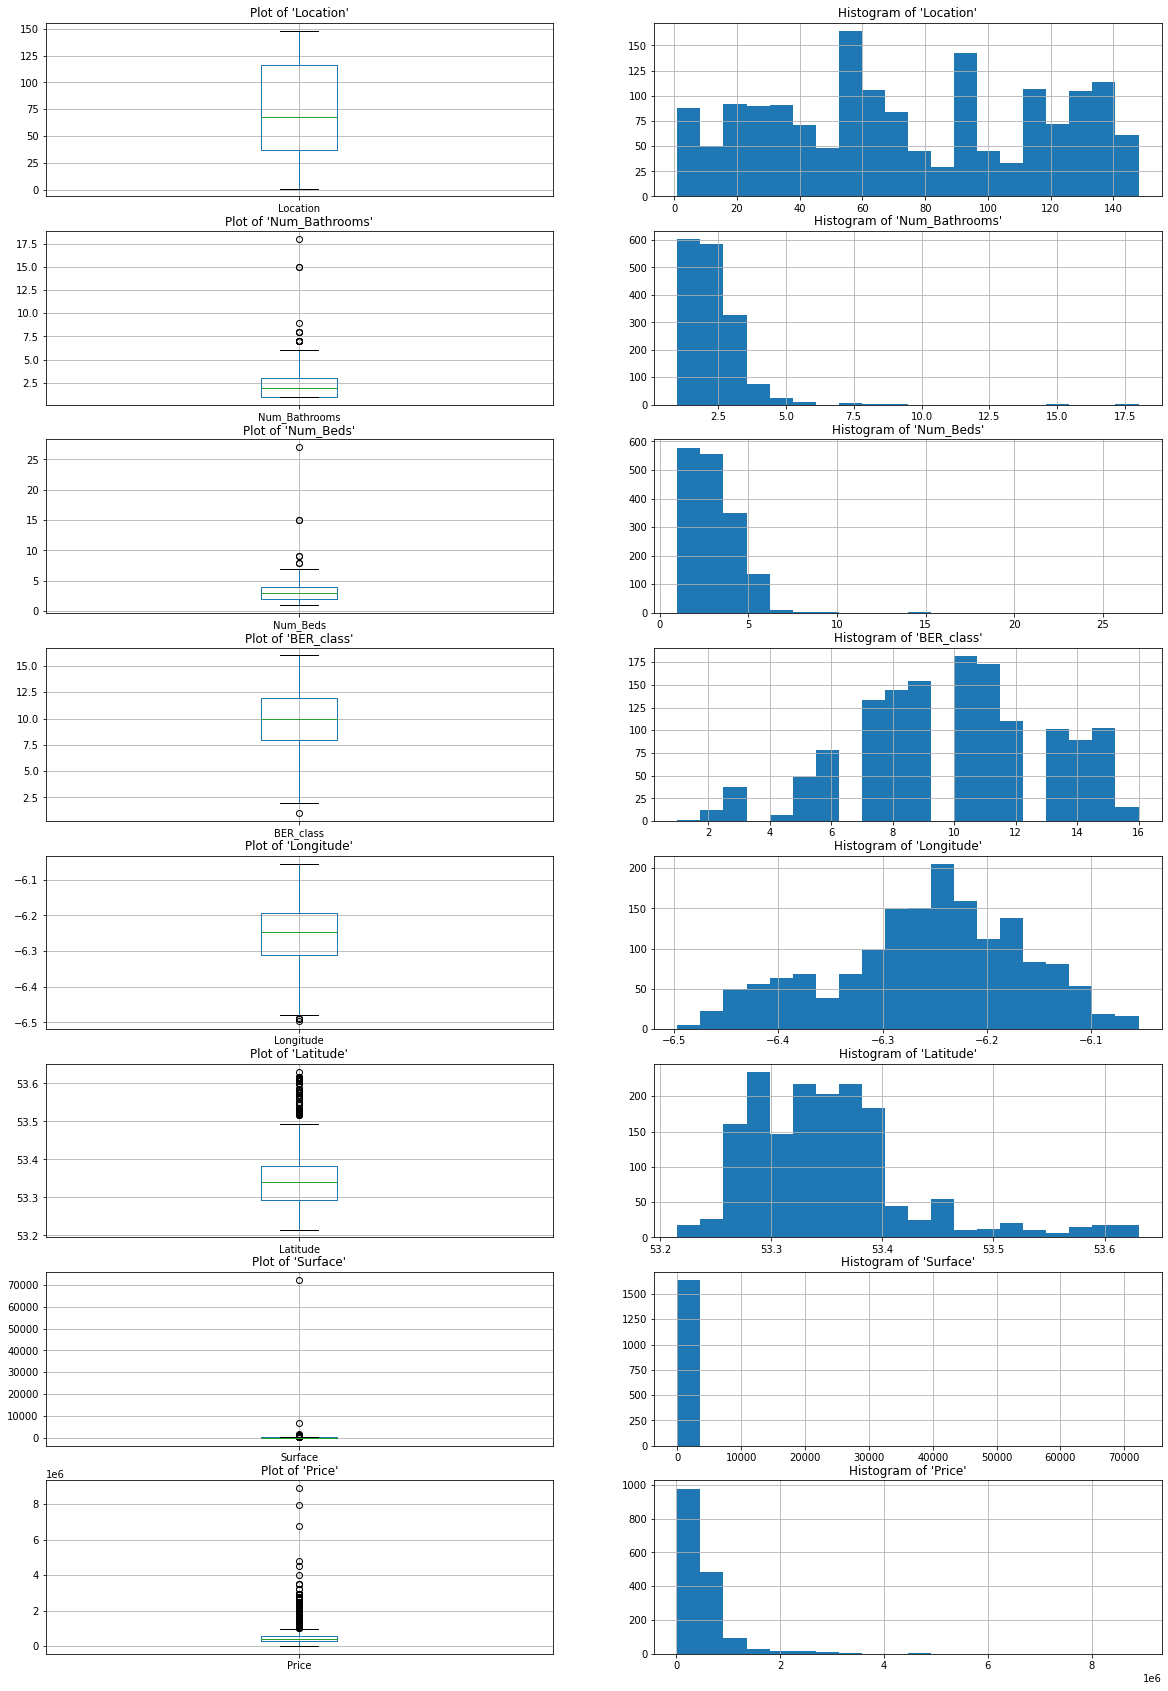

In [151]:
# First we will look at the distribution of key predictor features

fig = plt.figure(figsize=(20,30))

ax1 = fig.add_subplot(8, 2, 1)
ax1.set_title("Plot of 'Location'")
df_train.boxplot(column=['Location'])

ax2 = fig.add_subplot(8, 2, 2)
ax2.set_title("Histogram of 'Location'")
df_train['Location'].hist(bins=20)

ax3 = fig.add_subplot(8, 2, 3)
ax3.set_title("Plot of 'Num_Bathrooms'")
df_train.boxplot(column=['Num_Bathrooms'])

ax4 = fig.add_subplot(8, 2, 4)
ax4.set_title("Histogram of 'Num_Bathrooms'")
df_train['Num_Bathrooms'].hist(bins=20)

ax5 = fig.add_subplot(8, 2, 5)
ax5.set_title("Plot of 'Num_Beds'")
df_train.boxplot(column=['Num_Beds'])

ax6 = fig.add_subplot(8, 2, 6)
ax6.set_title("Histogram of 'Num_Beds'")
df_train['Num_Beds'].hist(bins=20)

ax7 = fig.add_subplot(8, 2, 7)
ax7.set_title("Plot of 'BER_class'")
df_train.boxplot(column=['BER_class'])

ax8 = fig.add_subplot(8, 2, 8)
ax8.set_title("Histogram of 'BER_class'")
df_train['BER_class'].hist(bins=20)

ax9 = fig.add_subplot(8, 2, 9)
ax9.set_title("Plot of 'Longitude'")
df_train.boxplot(column=['Longitude'])

ax10 = fig.add_subplot(8, 2, 10)
ax10.set_title("Histogram of 'Longitude'")
df_train['Longitude'].hist(bins=20)

ax11 = fig.add_subplot(8, 2, 11)
ax11.set_title("Plot of 'Latitude'")
df_train.boxplot(column=['Latitude'])

ax12 = fig.add_subplot(8, 2, 12)
ax12.set_title("Histogram of 'Latitude'")
df_train['Latitude'].hist(bins=20)

ax13 = fig.add_subplot(8, 2, 13)
ax13.set_title("Plot of 'Surface'")
df_train.boxplot(column=['Surface'])

ax14 = fig.add_subplot(8, 2, 14)
ax14.set_title("Histogram of 'Surface'")
df_train['Surface'].hist(bins=20)

ax15 = fig.add_subplot(8, 2, 15)
ax15.set_title("Plot of 'Price'")
df_train.boxplot(column=['Price'])

ax16 = fig.add_subplot(8, 2, 16)
ax16.set_title("Histogram of 'Price'")
df_train['Price'].hist(bins=20)

There is an outlier on 'Surface' that needs to be investigated

In [152]:
df_train[(df_train.Surface > 2000)]

,Index,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Features,Latitude,Longitude,Surface,Price,Type_apartment,Type_bungalow,Type_detached,Type_duplex,Type_end-of-terrace,Type_semi-detached,Type_site,Type_studio,Type_terraced,Type_townhouse
506,507,138,1,4,12.0,Thornton Park is a superb modern equestrian ce...,None,53.474502,-6.343483,72236.38714,1100000,0,1,0,0,0,0,0,0,0,0
1115,1116,19,1,2,13.0,Baxter Real Estate are delighted to present to...,Short drive to the N3 and M50 .\nSuitable for ...,53.386540,-6.377356,6705.00000,425000,0,1,0,0,0,0,0,0,0,0


There is only two values in the range greater than 2,000. Decision to remove it seems valid.

In [153]:
df_train = df_train.drop(df_train[df_train.Surface > 2000].index)

In [154]:
# Apply scalers to data to resolve distribution and outlier issues
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
standardscaler = StandardScaler()

# Not a normal distribution so just scale with MinMax [0, 1]
df_train[['Location']] = minmax.fit_transform(df_train[['Location']])

# Deal with outliers with a Log Transform - later we will use Standard Scaler as well on some feature
df_train['Num_Bathrooms'] = np.log(df_train['Num_Bathrooms'])

df_train['Num_Beds'] = np.log(df_train['Num_Beds'])

df_train['Latitude'] = np.log(df_train['Latitude'])

df_train['Surface'] = np.log(df_train['Surface'])

df_train['Price'] = np.log(df_train['Price'])

# Standard scaler for normal distributions
df_train[['BER_class', 'Longitude', 'Latitude', 'Surface', 'Price']] = standardscaler.fit_transform(df_train[['BER_class', 'Longitude', 'Latitude', 'Surface', 'Price']])


Do the same scaling to the Test Data

In [155]:
# Check for missing values in Training data - calculate % misisng values
test_missing = test_data.isnull().sum()*100/len(test_data)
print(test_missing)

Index             0.000000
ID                0.000000
Location          0.000000
Num_Bathrooms     0.000000
Num_Beds          0.000000
BER_class        15.384615
Description       0.000000
Services         64.957265
Features          0.000000
Latitude          0.000000
Longitude         0.000000
Type              0.000000
Surface           0.000000
dtype: float64


In [156]:
# Drop unimportant features

test_data.drop(['ID', 'Services'], axis=1, inplace=True)


In [157]:
df_test = test_data.copy()

In [158]:
# Let's deal with categorical data for Test Dataset

# Replace area name with the index from the 'unique_areas_index' dictionary 
df_test_1 = df_test.replace({'Location': unique_areas_index})

# Replace BER_class with the index from the 'unique_ber_index' dictionary 
df_test_2 = df_test_1.replace({'BER_class': unique_ber_index})

# One-hot Encode 'Type'
df_test_2 = pd.get_dummies(df_test_2, columns=['Type'])

df_test = df_test_2.copy()

# Take a copy of the Location and BER_class column before scaling - this will be used during imputing for NaNs later
loc_ber_test_values = df_test[['Location', 'BER_class']].copy()

# Apply same scalers as for Training dataset
df_test[['Location']] = minmax.fit_transform(df_test[['Location']])

df_test['Num_Bathrooms'] = np.log(df_test['Num_Bathrooms'])

df_test['Num_Beds'] = np.log(df_test['Num_Beds'])

df_test['Latitude'] = np.log(df_test['Latitude'])

df_test['Surface'] = np.log(df_test['Surface'])

# Standard scaler for normal distributions
df_test[['BER_class', 'Longitude', 'Latitude', 'Surface']] = standardscaler.fit_transform(df_test[['BER_class', 'Longitude', 'Latitude', 'Surface']])


Now let's look at 'BER_class' and see how important it is for predicting price.
The following approach uses XGBoost Regression algorithm which has some powerful built in functions for Feature Importance.

In [171]:
# Let's take a closer look at 'BER_class' using feature importance on all data set
# We will look at the feature Importance of 'BER_class' with empty features removed from the dataset 
# and left in to see check the impact also for imputation.

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

def xgb_model(X, y, msg):

  xgb_model = xgb.XGBRegressor(max_depth=7, learning_rate = 0.6, n_jobs=4, objective = 'reg:squarederror', random_state=10, n_estimators=50).fit(X, y)

  y_train_xgb_pred = xgb_model.predict(X)

  RMSE_xgb_train = mean_squared_error(y, y_train_xgb_pred, squared=False)

  r2_xgb_train = r2_score(y, y_train_xgb_pred)

  print(msg)

  print("RMSE_train: %.4f   R2_score: %.4f" %(RMSE_xgb_train, r2_xgb_train))

  return xgb_model, RMSE_xgb_train, r2_xgb_train

In [173]:
# Let's look at the Feature Importance with all BER_class values equal to NULL removed
# We will also remove large text features for now.

features = ['Location', 'Num_Bathrooms', 'Num_Beds', 'BER_class',
                        'Latitude', 'Longitude', 'Surface', 'Type_apartment', 
                        'Type_bungalow', 'Type_detached', 'Type_duplex',
                        'Type_end-of-terrace', 'Type_semi-detached', 'Type_site', 'Type_studio',
                        'Type_terraced', 'Type_townhouse', 'Price']

df_train_xgb = df_train[features]
X_train_xgb = df_train_xgb.iloc[:,0:-1].values 
y_train_xgb = df_train_xgb.iloc[:,-1].values.reshape(-1,1)  

df_train_xgb_partial = df_train_xgb.dropna(how='all', subset=['BER_class'])
X_train_xgb_partial = df_train_xgb_partial.iloc[:,0:-1].values
y_train_xgb_partial = df_train_xgb_partial.iloc[:,-1].values.reshape(-1,1) 

# Call XGBoost Model for each dataset

Model_Full, RMSE_xgb_train_full, r2_xgb_train_full = xgb_model(X_train_xgb, y_train_xgb, "Performance Evaluation for Full Training Set")

Model_Partial, RMSE_xgb_train_partial, r2_xgb_train_partial = xgb_model(X_train_xgb_partial, y_train_xgb_partial, "Performance Evaluation for NaNs Removed")



Performance Evaluation for Full Training Set
RMSE_train: 0.0323   R2_score: 0.9990
Performance Evaluation for NaNs Removed
RMSE_train: 0.0323   R2_score: 0.9990


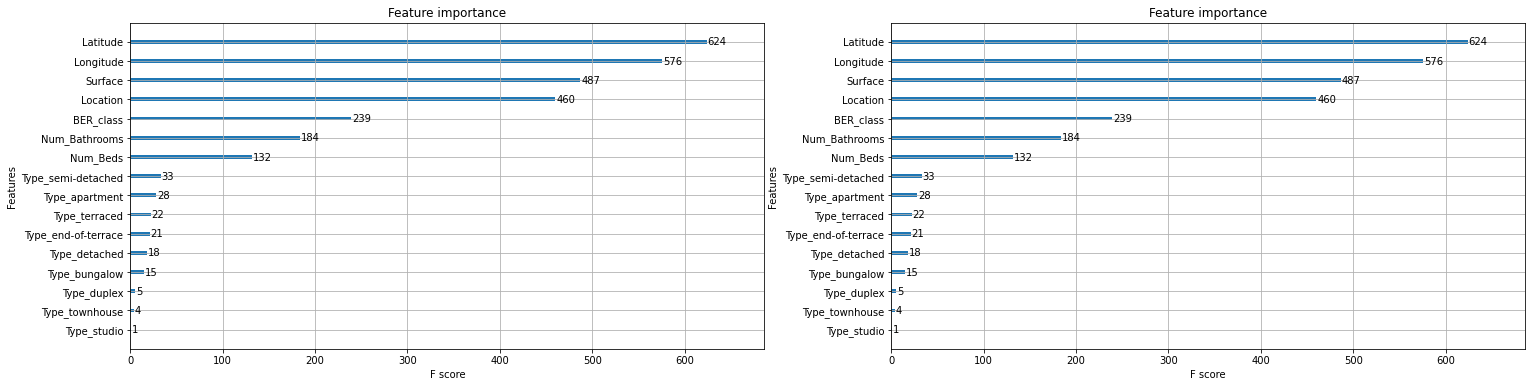

In [174]:
# Let's plot the Feature Importance for each of these solutions

import seaborn as sn

fig = plt.figure(figsize=(25,6))

Model_Full.get_booster().feature_names = features[:-1]
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Plot of Feature Importance for Full Model")
xgb.plot_importance(Model_Full, max_num_features= 17, ax=ax1, importance_type="weight")

Model_Partial.get_booster().feature_names = features[:-1]
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Plot of Feature Importance for Model with NaNs removed.")
xgb.plot_importance(Model_Partial, max_num_features= 17, ax=ax2, importance_type="weight")

plt.show()


**Analysis of Plots** It can be seen from the above plots of Training Dataset with NaNs removed (plot on right) and NaNs left (plot on left) in that both plots confirm the importance of BER_class. XGBoost handles NaN values by default but we cannot expect that all models wil do so. We will keep the BER_class and compute imputed values for missing data.

Note also that both models agree on the overall importance of features. The Top 7 Features have a greater influence on model performance. It seems that property 'Type' is not so important.

For this exercise, I will concentrate on the Top 7 key features and remove the 'Type'

#### Imputing BER_class value: replace NaNs with average BER by location

In [175]:
# First we will determine the average BER_class for each Location.
# This approach was taken because many locations have a mix of BER ratings (determined from analysis)
# but are, in general, either new development areas or mature development areas and as such 
# are likely to have ratings within a range based on maturity of the location as a whole.

# Determine the average BER_class rating by location
feat = ['Location', 'BER_class']
train_feat = df_train_2[feat]
test_feat =  df_test_2[feat]
train_test_stack = pd.concat([train_feat, test_feat])

average_vals = train_test_stack.groupby(['Location'], dropna=True)['BER_class'].mean().round()


**Comment** The code above creates a lookup of Average BER_class by Location. However, this is not a perfect lookup as there are several locations in the combined Training and Test datasets that have only one property in certain locations and these properties have a NaN value for BER_class. This means that the lookup will not be able to replace these NaNs with and average. Tests have shown that the effect is limited and the BER_class is improved from 15.4% missing values to 0.1% missing values. 

In [176]:
# Look for NaNs and replace them with the average for the given location
import math

def impute_ber(data):
  for index, row in data.iterrows():
    if math.isnan(row['BER_class']): 
      loc = row['Location']
      lookup_ber = average_vals.loc[loc]
      data.loc[index, "BER_class"] = lookup_ber
  return data

In [177]:
# Impute BER_class on training data
ber_tr_values = impute_ber(loc_ber_train_values)

# Impute BER_class on test data
ber_ts_values = impute_ber(loc_ber_test_values)

# There are still a very small number (2 in both training and test datsets) of NaNs due to single properties in locations that have NaNs and therefore could not be averaged
# We will apply an average over the entire feature for BER_class to populate these
ber_tr_values['BER_class'].fillna((ber_tr_values['BER_class'].mean()), inplace=True)
ber_ts_values['BER_class'].fillna((ber_ts_values['BER_class'].mean()), inplace=True)

# We can apply the standard scaler to each of the training and test set BER_class features
ber_tr_values[['BER_class']] = standardscaler.fit_transform(ber_tr_values[['BER_class']])
ber_ts_values[['BER_class']] = standardscaler.fit_transform(ber_ts_values[['BER_class']])

# Then we insert these columns back into the df_train and df_test datasets
df_train['BER_class'] = ber_tr_values['BER_class']
df_test['BER_class'] = ber_ts_values['BER_class']

In [181]:
# Let's test for any performance changes with the XGBoost Model

# Remove 'Type' from dataset as it does not appear to be too important
features = ['Location', 'Num_Bathrooms', 'Num_Beds', 'BER_class',
                        'Latitude', 'Longitude', 'Surface','Price']

df_train_xgb = df_train[features]
X_train_xgb = df_train_xgb.iloc[:,0:-1].values 
y_train_xgb = df_train_xgb.iloc[:,-1].values.reshape(-1,1)  

# Call XGBoost Model for each dataset
Model_Full, RMSE_xgb_train_full, r2_xgb_train_full = xgb_model(X_train_xgb, y_train_xgb, "Performance Evaluation for Full Training Set")


Performance Evaluation for Full Training Set
RMSE_train: 0.0410   R2_score: 0.9983


**Comment** The performance of the XGBoost Model has not shown much improvement with the imputing of missing BER_values. However, that is expected as XGBoost handles missing values by default. We expect to see no great impact on the model, but no deterioration.

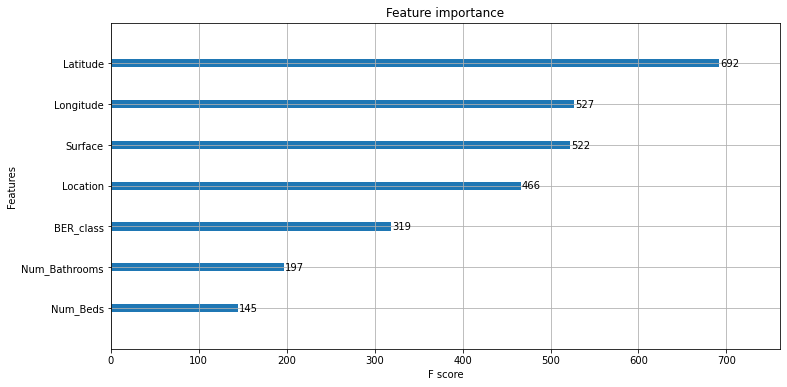

In [180]:
# Plot the Feature Importance to see what the impact of imputing BER_class has been
fig, ax = plt.subplots(figsize=(12, 6))

Model_Full.get_booster().feature_names = features[:-1]
xgb.plot_importance(Model_Full, max_num_features= 7, ax=ax, importance_type="weight")
plt.show()

**Comment** As mentioned above, we expect to see no great change from in either BER_class feature importance. Key here is the model performs well with the newly processed data and that is confirmed. We want to process the data to perform well with models that do not handle missing data well and that is what we have done here.

### Analysis of Exploratory Data Analysis and Feature Engineering/Preprocessing
**Explain the approach, setps and results**

**Discuss the imputing for BER_class**
>>1) Not much impact and 

>>2) not expected with XGBoost but will be important for modelling with algorithms that do not handle NaNs as well as XGBoost>

**Discuss the Type feature(s)** and the fact they do not look useful and may be removed from further processing


**The data is fully processed and ready for next stage - NLP Processing**

## Training & Test Data

The training and test datasets have been fully processed by removing unnecessary columns removing erroneous records, scaling and imputing values to provide complete datasets ready for further processing.

### Train dataset

In [41]:
# show first data frame rows 
df_train.head()

,Index,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Features,Latitude,Longitude,Surface,Price,Type_apartment,Type_bungalow,Type_detached,Type_duplex,Type_end-of-terrace,Type_semi-detached,Type_site,Type_studio,Type_terraced,Type_townhouse
0,1,0.727891,0.693147,0.693147,-0.315848,DNG are delighted to present to the market no....,None,0.620414,-1.972920,-0.801032,-1.375767,1,0,0,0,0,0,0,0,0,0
1,2,0.714286,0.000000,0.693147,0.027283,13 Northbrook Terrace is a charming red brick ...,Bight and Spacious interior\nNumerous original...,0.085158,0.195426,-0.129563,-0.069313,0,0,0,0,0,0,0,0,1,0
2,3,0.911565,1.098612,1.098612,-2.374633,"Welcome to No. 6 Cotter Close, an immaculately...",Special Features\nLarge rear garden\nGenerous ...,-1.143935,0.380738,0.073728,0.316671,0,0,0,0,0,1,0,0,0,0
3,4,0.149660,0.000000,1.098612,0.713544,Welcome to 3 Sycamore Walk!\n\r\nEnjoying a pr...,Wonderful 3 bed detached bungalow. \nAccom...,-1.209989,0.991249,-0.446453,0.199858,0,0,1,0,0,0,0,0,0,0
4,5,0.639456,1.098612,1.386294,0.027283,'Four Seasons' comes to the market as a wonder...,Detached Property \nDouble Glazed Windows...,2.702848,1.485068,0.741957,0.236422,0,0,1,0,0,0,0,0,0,0


In [42]:
# Generate descriptive statistics
df_train.describe()

,Index,Location,Num_Bathrooms,Num_Beds,BER_class,Latitude,Longitude,Surface,Price,Type_apartment,Type_bungalow,Type_detached,Type_duplex,Type_end-of-terrace,Type_semi-detached,Type_site,Type_studio,Type_terraced,Type_townhouse
count,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1.635000e+03,1.635000e+03,1.635000e+03,1.635000e+03,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000
mean,819.793272,0.499586,0.584805,1.025529,-0.001083,-2.551883e-14,2.844887e-15,-4.305085e-17,-6.779151e-16,0.263609,0.028135,0.143119,0.020183,0.072171,0.279511,0.000612,0.001223,0.182875,0.008563
std,473.169234,0.291108,0.508900,0.426905,1.000420,1.000306e+00,1.000306e+00,1.000306e+00,1.000306e+00,0.440724,0.165408,0.350302,0.140671,0.258850,0.448896,0.024731,0.034964,0.386682,0.092166
min,1.000000,0.000000,0.000000,0.000000,-3.060895,-1.837444e+00,-2.607139e+00,-6.371178e+00,-5.194933e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,410.500000,0.244898,0.000000,0.693147,-0.658979,-7.665698e-01,-5.638635e-01,-6.407679e-01,-6.815719e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,820.000000,0.455782,0.693147,1.098612,0.027283,-1.297867e-01,1.086977e-01,-1.096150e-01,-1.920677e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1229.500000,0.782313,1.098612,1.386294,0.713544,4.214960e-01,6.931843e-01,5.080770e-01,4.949167e-01,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1638.000000,1.000000,2.890372,3.295837,2.086067,3.779837e+00,2.211758e+00,4.995069e+00,5.031338e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Comment** key to note here is the scales on all features are within similar ranges and not with large differences.

### Test dataset

In [43]:
# show first data frame rows 
df_test.head()

,Index,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Features,Latitude,Longitude,Surface,Type_apartment,Type_bungalow,Type_detached,Type_duplex,Type_end-of-terrace,Type_semi-detached,Type_site,Type_terraced,Type_townhouse
0,1639,0.655172,0.693147,0.693147,-0.616615,OMD Estate Agents are delighted to present thi...,Designated parking spaces\nPresented in pristi...,-0.462275,0.098546,-0.854973,0,0,0,0,0,0,0,0,1
1,1640,0.448276,0.693147,1.609438,0.689377,Welcome to Saint Anthony No.214 Glasnevin Aven...,Modern Worcester Gas Boiler\nSingle Glazed Win...,0.546564,-0.322551,0.571829,0,0,0,0,0,1,0,0,0
2,1641,0.275862,0.000000,0.693147,1.668871,"Located in this ever popular road, on grounds ...",2 BEDROOM DETACHED HOUSE ON 1/5th ACRE\nOIL F...,-1.055818,1.570297,-0.475852,0,0,1,0,0,0,0,0,0
3,1642,0.772414,1.386294,1.386294,-2.575603,DNG are delighted to represent the sale of thi...,Detached House\nSouth Facing Garden\nOff Stree...,0.359297,0.732808,1.277538,0,0,1,0,0,0,0,0,0
4,1643,0.268966,0.693147,1.098612,1.342373,A unique opportunity to acquire this red brick...,Red brick end of terrace property \nC. 108sqm ...,-0.314053,-0.617542,0.072098,0,0,0,0,1,0,0,0,0


In [44]:
# Generate descriptive statistics
df_test.describe()

,Index,Location,Num_Bathrooms,Num_Beds,BER_class,Latitude,Longitude,Surface,Type_apartment,Type_bungalow,Type_detached,Type_duplex,Type_end-of-terrace,Type_semi-detached,Type_site,Type_terraced,Type_townhouse
count,702.000000,702.000000,702.000000,702.000000,7.020000e+02,7.020000e+02,7.020000e+02,7.020000e+02,702.000000,702.000000,702.00000,702.000000,702.000000,702.000000,702.000000,702.000000,702.000000
mean,1989.500000,0.507663,0.580580,1.013545,-3.722885e-16,5.027555e-14,6.153356e-15,1.031147e-16,0.276353,0.025641,0.14245,0.021368,0.091168,0.245014,0.002849,0.188034,0.007123
std,202.794231,0.291095,0.498537,0.415753,1.000713e+00,1.000713e+00,1.000713e+00,1.000713e+00,0.447512,0.158175,0.34976,0.144709,0.288053,0.430402,0.053338,0.391018,0.084154
min,1639.000000,0.000000,0.000000,0.000000,-2.575603e+00,-1.846362e+00,-2.936280e+00,-2.143177e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1814.250000,0.270690,0.000000,0.693147,-6.166147e-01,-7.474966e-01,-5.664116e-01,-6.430413e-01,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1989.500000,0.462069,0.693147,1.098612,3.638120e-02,-1.251458e-01,5.039519e-02,-8.309184e-02,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2164.750000,0.793103,1.098612,1.386294,6.893772e-01,4.245285e-01,7.443558e-01,5.047100e-01,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2340.000000,1.000000,2.197225,2.639057,1.995369e+00,3.607425e+00,2.133195e+00,8.059505e+00,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# NATURAL LANGUAGE PROCESSING

Natural language processing ([NLP](https://en.wikipedia.org/wiki/Natural_language_processing)) is a subfield of linguistics, computer science, and artificial intelligence.

* NLP concerned with the interactions between computers and human language.
* In particular how to program computers to process and analyze large amounts of natural language data. 
* The goal is a computer capable of "understanding" the contents of documents.
* Including the contextual nuances of the language within them. 
* The technology can then accurately extract information and insights contained in the documents.
* As well as categorize and organize the documents themselves. 

For this section, we will process the two textual features using NLP techniqus. The two textual features are:

1. Description

2. Features

We are looking to see if these features have an impact on price. There maybe some words or phrases (bi- or tri-grams) that may influence the Price paid for the propertes. This is interesting because these are typically used by sellers or estate agents to dscribe the prperty for sale. The use of descriptions like this, as well as more detail on features of the prperty, are likely to influence buyers, so we will test this.

In [45]:
# Set up the various components of the NLP processing code

from nltk.tokenize import word_tokenize  
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
nltk.download('punkt')
nltk.download('wordnet')
import nltk
nltk.download('stopwords')

def nlp_preprocess(some_text):
  """
  Normalization using NLTK and spaCy
  """
  # 1. Tokenization
  NLP_token = word_tokenize(some_text)

  # 2. Stemming
  PS = PorterStemmer()
  NLP_stem = []
  for word in NLP_token:
      NLP_stem.append(PS.stem(word))

  # 3. Lemmatization
  WL = WordNetLemmatizer()
  NLP_lemma = []
  for word in NLP_stem:
      NLP_lemma.append(WL.lemmatize(word))
  
  # 4. Stopword   
  FS = []  
  NLP_stop = set(stopwords.words("english"))
  for w in NLP_lemma:  
      if w not in NLP_stop:  
        FS.append(w)
  
  # 5. Punctuation  
  punctuations = "?:!.,;"
  for word in FS:
      if word in punctuations:
          FS.remove(word)

  # print comparison
  print(" ")
  print(some_text)
  print(FS)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [47]:
training_first = df_train.head(1)

descr_str = training_first['Features']

description = re.sub("[^a-zA-Z]", " ", str(descr_str))

nlp_preprocess(description)

print(description)

 
     DNG are delighted to present to the market no     Name  Description  dtype  object
['dng', 'delight', 'present', 'market', 'name', 'descript', 'dtype', 'object']
     DNG are delighted to present to the market no     Name  Description  dtype  object


# PIECEWISE REGRESSION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

In [198]:
df_train['Price'] = train_data['Price'] # put original pice back in the dataset

### Bayesian Model Price Prediction on dataset with Full 7 key features as determined above in EDA Section

In [200]:
# List of key features determined from EDA and XGBoost Feature Importance Analysis

featrain = ['Location', 'Num_Bathrooms', 'Num_Beds', 'BER_class','Latitude', 'Longitude', 'Surface', 'Price']
featest = ['Location', 'Num_Bathrooms', 'Num_Beds', 'BER_class','Latitude', 'Longitude', 'Surface']

df_subset_train = df_train[featrain]
df_subset_test = df_test[featest]

In [201]:
# Separate training data into target 'y' and predictor 'X' values

# train set, input columns
X_train = df_subset_train.iloc[:,0:-1].values 
# train set, output column, cost
y_train = df_subset_train.iloc[:,-1].values.reshape(-1,1)   

# test set, input columns
X_test = df_subset_test.iloc[:,0:].values 


In [202]:
# Scale y_train 'price' values

ylog = np.log(y_train.astype('float'))
yscaler = StandardScaler().fit(ylog)
y_train = yscaler.transform(ylog)

In [203]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=X_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, X_train.T)
    #likelihood, be sure that observed is a 1d vector
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=y_train[:,0])

Finished [100%]: Average Loss = 1,237.6


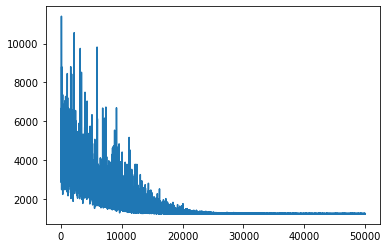

In [204]:
#number of iterations of the algorithms
iter = 50000

# run the model
with model:
    approximation = pm.fit(iter,method='advi')
    
# check the convergence
plt.plot(approximation.hist);

In [205]:
# samples from the posterior
posterior = approximation.sample(draws=2000)

In [207]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), X_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print(len(y_pred_BLR))

702


In [223]:
df_1 = test_data['Index']
df_2 = pd.DataFrame(y_pred_BLR, columns=['Price'])
full_test_predictions = pd.concat([df_1, df_2], axis=1)
full_test_predictions

,Index,Price
0,1639,326901.840239
1,1640,513914.772386
2,1641,551866.287752
3,1642,763503.415604
4,1643,472047.039525
...,...,...
697,2336,207489.367432
698,2337,248278.198450
699,2338,527802.268281
700,2339,562343.428697


In [224]:
# Save this file as a CSV

full_test_predictions.to_csv(path+'ET5003_Kaggle_RobertBarrett_20157347.csv')

### Price Prediction using Piecewise Bayesian Model

# BAYESIAN NN

A [Bayesian network](https://en.wikipedia.org/wiki/Bayesian_network) (also known as a Bayes network, Bayes net, belief network, or decision network) is a probabilistic graphical model that represents a set of variables and their conditional dependencies via a directed acyclic graph (DAG). 

* Bayesian networks are ideal for taking an event that occurred and predicting the likelihood that any one of several possible known causes was the contributing factor. 
* For example, a Bayesian network could represent the probabilistic relationships between diseases and symptoms. 
* Given symptoms, the network can be used to compute the probabilities of the presence of various diseases.

Your comments, explanation, and references here.

In [225]:
# Instantiate Kernel
kernel = GPy.kern.RBF(input_dim=1,lengthscale=0.15,variance=0.2)
print(kernel)

  rbf.         |  value  |  constraints  |  priors
  variance     |    0.2  |      +ve      |        
  lengthscale  |   0.15  |      +ve      |        


In [247]:
# https://theano-pymc.readthedocs.io/en/latest/
import theano

# add a column of ones to include an intercept in the model
x1 = np.hstack([np.ones((X_train.shape[0],1)), X_train])
floatX = theano.config.floatX

In [250]:
l = 15
# Initialize random weights between each layer
# we do that to help the numerical algorithm that computes the posterior
init_1 = np.random.randn(x1.shape[1], l).astype(floatX)
init_out = np.random.randn(l).astype(floatX)

# pymc3 model as neural_network
with pm.Model() as neural_network:
    # we convert the data in theano type so we can do dot products with the correct type.
    ann_input = pm.Data('ann_input', x1)
    ann_output = pm.Data('ann_output', y_train)
    # Priors 
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_1', 0, sigma=1,
                             shape=(x1.shape[1], l), testval=init_1)
    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_0', 0, sigma=1,
                              shape=(l,),testval=init_out)

    # Build neural-network using tanh activation function
    # Inner layer
    act_1 = pm.math.tanh(pm.math.dot(ann_input,weights_in_1))
    # Linear layer, like in Linear regression
    act_out = pm.Deterministic('act_out',pm.math.dot(act_1, weights_2_out))

    # standard deviation of noise
    sigma = pm.HalfCauchy('sigma',5)

    # Normal likelihood
    out = pm.Normal('out',
                       act_out,
                       sigma=sigma,
                       observed=ann_output[:,0])

In [266]:
# we can do instead an approximated inference
param3 = 20000 # start with 1000, then use 50000+
VI = 'advi'  # 'advi', 'fullrank_advi', 'svgd', 'asvgd', 'nfvi'
OP = pm.adam # pm.adam, pm.sgd, pm.adagrad, pm.adagrad_window, pm.adadelta
LR = 0.01    

with neural_network:
    approx = pm.fit(param3, method=VI, obj_optimizer=pm.adam(learning_rate=LR))

Finished [100%]: Average Loss = 940.44


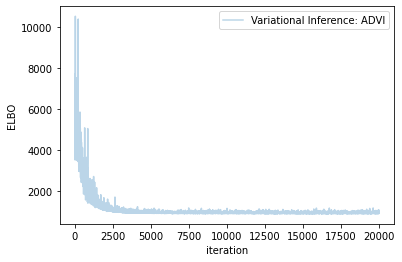

In [268]:
# plot 
pb.plot(approx.hist, label='Variational Inference: '+ VI.upper(), alpha=.3)
pb.legend(loc='upper right')
# Evidence Lower Bound (ELBO)
# https://en.wikipedia.org/wiki/Evidence_lower_bound
pb.ylabel('ELBO')
pb.xlabel('iteration');

In [269]:
# draw samples from variational posterior
D = 702
posterior = approx.sample(draws=D)

In [272]:
# add a column of ones to include an intercept in the model
x2 = np.hstack([np.ones((X_test.shape[0],1)), X_test])

y_pred = []
for i in range(posterior['w_1'].shape[0]):
    #inner layer
    t1 = np.tanh(np.dot(posterior['w_1'][i,:,:].T,x2.T))
    #outer layer
    y_pred.append(np.dot(posterior['w_0'][i,:],t1))

# predictions   
y_pred = np.array(y_pred)

In [276]:
y_pred.shape

(702, 702)

In [282]:
# prediction
y_pred_BLR = np.exp(yscaler.inverse_transform(y_pred))[:,0]

# Let's check how close these are to the Full Mdel Predictions (Piecewise Approach)
df_1 = full_test_predictions.copy()
df_2 = pd.DataFrame(y_pred_BLR, columns=['Price_NN'])
full_test_predictions = pd.concat([df_1, df_2], axis=1)
full_test_predictions

,Index,Price,Price_NN
0,1639,326901.840239,443275.897025
1,1640,513914.772386,444595.127407
2,1641,551866.287752,437858.588397
3,1642,763503.415604,453980.112553
4,1643,472047.039525,422653.265001
...,...,...,...
697,2336,207489.367432,434576.689206
698,2337,248278.198450,429547.498199
699,2338,527802.268281,412884.134164
700,2339,562343.428697,432390.987690


In [281]:
full_test_predictions.drop(columns=['Price_NN'], inplace=True)

# SUMMARY

Your summary here.